In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader

## Find files to load and create Dataset

In [2]:
all_inputs = [
    f
    for f in
    Path('/kaggle/input/waveform-inversion/train_samples').rglob('*.npy')
    if ('seis' in f.stem) or ('data' in f.stem)
]

In [3]:
def inputs_files_to_output_files(input_files):
    return [
        Path(str(f).replace('seis', 'vel').replace('data', 'model'))
        for f in input_files
    ]

all_outputs = inputs_files_to_output_files(all_inputs)

In [4]:
assert all(f.exists() for f in all_outputs)

In [5]:
train_inputs = [all_inputs[i] for i in range(0, len(all_inputs), 2)] # Sample every two
valid_inputs = [f for f in all_inputs if not f in train_inputs]

In [6]:
train_outputs = inputs_files_to_output_files(train_inputs)
valid_outputs = inputs_files_to_output_files(valid_inputs)

In [7]:
class SeismicDataset(Dataset):
    def __init__(self, inputs_files, output_files, n_examples_per_file=500):
        assert len(inputs_files) == len(output_files)
        self.inputs_files = inputs_files
        self.output_files = output_files
        self.n_examples_per_file = n_examples_per_file

    def __len__(self):
        return len(self.inputs_files) * self.n_examples_per_file

    def __getitem__(self, idx):
        # Calculate file offset and sample offset within file
        file_idx = idx // self.n_examples_per_file
        sample_idx = idx % self.n_examples_per_file

        X = np.load(self.inputs_files[file_idx], mmap_mode='r')
        y = np.load(self.output_files[file_idx], mmap_mode='r')

        try:
            return X[sample_idx].copy(), y[sample_idx].copy()
        finally:
            del X, y

In [8]:
dstrain = SeismicDataset(train_inputs, train_outputs)
dltrain = DataLoader(dstrain, batch_size=64, shuffle=True, pin_memory=True, drop_last=True, num_workers=4, persistent_workers=True)

dsvalid = SeismicDataset(valid_inputs, valid_outputs)
dlvalid = DataLoader(dsvalid, batch_size=64, shuffle=False, pin_memory=True, drop_last=False, num_workers=4, persistent_workers=True)

## DumbNet

In [9]:
class DumbNet(nn.Module):
    '''DumbNet is just a MLP Model, with a avg-pool first to reduze input size'''
    def __init__(self, pool_size=(8, 2), input_size=5 * 1000 * 70, hidden_size=70 * 70, output_size=70 * 70):
        super().__init__()

        self.pool = nn.AvgPool2d(kernel_size=pool_size)

        self.model = nn.Sequential(
            nn.Linear(input_size // (pool_size[0] * pool_size[1]), hidden_size),
            
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(hidden_size, hidden_size),

            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, x):
        bs = x.shape[0]

        # We apply a pool to reduze input size
        x_pool = self.pool(x)

        #Model is just a
        out = self.model(x_pool.view(bs, -1))

        return out.view(bs, 1, 70, 70) * 1000 + 1500

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [11]:
model = DumbNet().to(device)

## Train loop

In [12]:
criterion = nn.L1Loss()
optim = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)

[01] Begin train


train:   0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 541.32095


valid:   0%|          | 0/79 [00:00<?, ?it/s]

Valid loss: 438.94538
[02] Begin train


train:   0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 440.22012


valid:   0%|          | 0/79 [00:00<?, ?it/s]

Valid loss: 420.53673
[03] Begin train


train:   0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 424.81578


valid:   0%|          | 0/79 [00:00<?, ?it/s]

Valid loss: 421.87427
[04] Begin train


train:   0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 410.70153


valid:   0%|          | 0/79 [00:00<?, ?it/s]

Valid loss: 428.00358


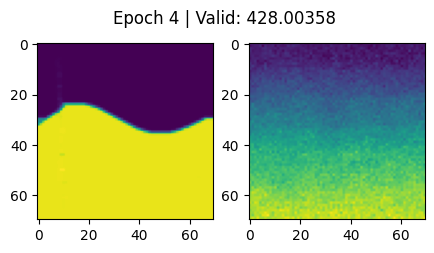

[05] Begin train


train:   0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 395.75569


valid:   0%|          | 0/79 [00:00<?, ?it/s]

Valid loss: 409.13999
[06] Begin train


train:   0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 384.57210


valid:   0%|          | 0/79 [00:00<?, ?it/s]

Valid loss: 387.66320
[07] Begin train


train:   0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 369.89945


valid:   0%|          | 0/79 [00:00<?, ?it/s]

Valid loss: 401.27874
[08] Begin train


train:   0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 363.62409


valid:   0%|          | 0/79 [00:00<?, ?it/s]

Valid loss: 380.14787


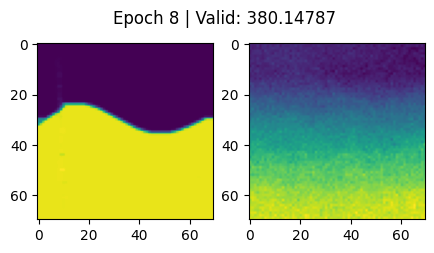

[09] Begin train


train:   0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 358.19027


valid:   0%|          | 0/79 [00:00<?, ?it/s]

Valid loss: 379.05616
[10] Begin train


train:   0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 347.30179


valid:   0%|          | 0/79 [00:00<?, ?it/s]

Valid loss: 377.18959
[11] Begin train


train:   0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 341.50682


valid:   0%|          | 0/79 [00:00<?, ?it/s]

Valid loss: 381.65693
[12] Begin train


train:   0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 338.54928


valid:   0%|          | 0/79 [00:00<?, ?it/s]

Valid loss: 386.57813


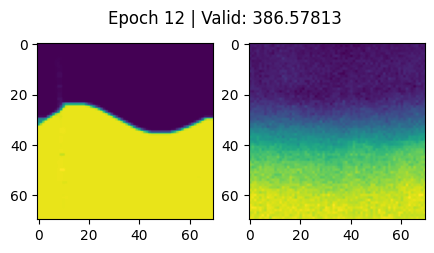

[13] Begin train


train:   0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 327.14547


valid:   0%|          | 0/79 [00:00<?, ?it/s]

Valid loss: 365.04149
[14] Begin train


train:   0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 322.15915


valid:   0%|          | 0/79 [00:00<?, ?it/s]

Valid loss: 352.41148
[15] Begin train


train:   0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 317.98331


valid:   0%|          | 0/79 [00:00<?, ?it/s]

Valid loss: 364.61670
[16] Begin train


train:   0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 313.45210


valid:   0%|          | 0/79 [00:00<?, ?it/s]

Valid loss: 347.76590


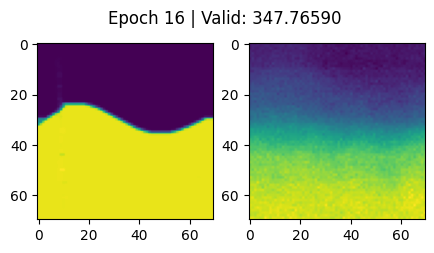

[17] Begin train


train:   0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 307.75279


valid:   0%|          | 0/79 [00:00<?, ?it/s]

Valid loss: 348.29269
[18] Begin train


train:   0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 303.29909


valid:   0%|          | 0/79 [00:00<?, ?it/s]

Valid loss: 346.76465
[19] Begin train


train:   0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 300.74097


valid:   0%|          | 0/79 [00:00<?, ?it/s]

Valid loss: 352.71096
[20] Begin train


train:   0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 297.16658


valid:   0%|          | 0/79 [00:00<?, ?it/s]

Valid loss: 346.69386


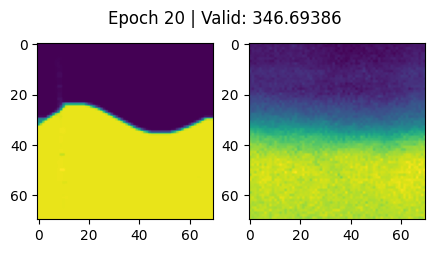

[21] Begin train


train:   0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 294.17487


valid:   0%|          | 0/79 [00:00<?, ?it/s]

Valid loss: 365.99618
[22] Begin train


train:   0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 290.38406


valid:   0%|          | 0/79 [00:00<?, ?it/s]

Valid loss: 337.49490
[23] Begin train


train:   0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 287.75376


valid:   0%|          | 0/79 [00:00<?, ?it/s]

Valid loss: 334.79762
[24] Begin train


train:   0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 283.60824


valid:   0%|          | 0/79 [00:00<?, ?it/s]

Valid loss: 347.69926


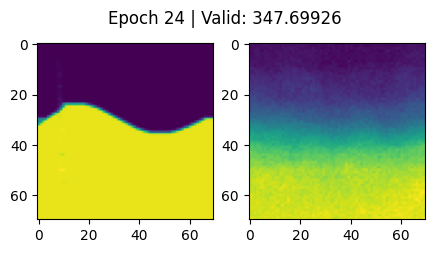

[25] Begin train


train:   0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 285.51127


valid:   0%|          | 0/79 [00:00<?, ?it/s]

Valid loss: 340.11393
[26] Begin train


train:   0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 281.46495


valid:   0%|          | 0/79 [00:00<?, ?it/s]

Valid loss: 334.46951
[27] Begin train


train:   0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 276.15701


valid:   0%|          | 0/79 [00:00<?, ?it/s]

Valid loss: 357.59391
[28] Begin train


train:   0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 277.61484


valid:   0%|          | 0/79 [00:00<?, ?it/s]

Valid loss: 339.47195


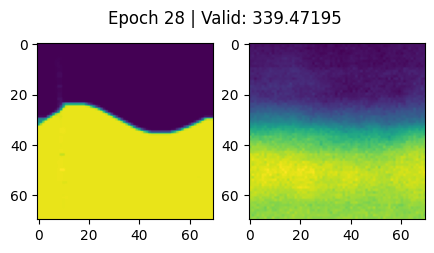

[29] Begin train


train:   0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 273.21300


valid:   0%|          | 0/79 [00:00<?, ?it/s]

Valid loss: 343.71494
[30] Begin train


train:   0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 269.74060


valid:   0%|          | 0/79 [00:00<?, ?it/s]

Valid loss: 352.03962
[31] Begin train


train:   0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 270.09958


valid:   0%|          | 0/79 [00:00<?, ?it/s]

Valid loss: 331.11802
[32] Begin train


train:   0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 265.71609


valid:   0%|          | 0/79 [00:00<?, ?it/s]

Valid loss: 334.99124


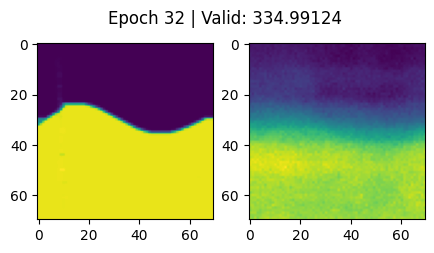

[33] Begin train


train:   0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 265.45291


valid:   0%|          | 0/79 [00:00<?, ?it/s]

Valid loss: 329.99787
[34] Begin train


train:   0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 263.81500


valid:   0%|          | 0/79 [00:00<?, ?it/s]

Valid loss: 328.65885
[35] Begin train


train:   0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 264.47458


valid:   0%|          | 0/79 [00:00<?, ?it/s]

Valid loss: 341.22300
[36] Begin train


train:   0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 261.97364


valid:   0%|          | 0/79 [00:00<?, ?it/s]

Valid loss: 337.21789


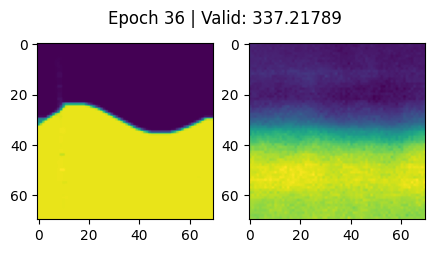

[37] Begin train


train:   0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 258.45150


valid:   0%|          | 0/79 [00:00<?, ?it/s]

Valid loss: 332.85294
[38] Begin train


train:   0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 256.90144


valid:   0%|          | 0/79 [00:00<?, ?it/s]

Valid loss: 343.04241
[39] Begin train


train:   0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 257.48589


valid:   0%|          | 0/79 [00:00<?, ?it/s]

Valid loss: 333.69121
[40] Begin train


train:   0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 254.47728


valid:   0%|          | 0/79 [00:00<?, ?it/s]

Valid loss: 332.72540


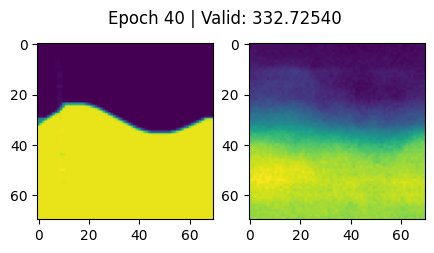

[41] Begin train


train:   0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 252.25016


valid:   0%|          | 0/79 [00:00<?, ?it/s]

Valid loss: 321.00171
[42] Begin train


train:   0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 250.25466


valid:   0%|          | 0/79 [00:00<?, ?it/s]

Valid loss: 321.33937
[43] Begin train


train:   0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 250.55758


valid:   0%|          | 0/79 [00:00<?, ?it/s]

Valid loss: 337.42325
[44] Begin train


train:   0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 251.52425


valid:   0%|          | 0/79 [00:00<?, ?it/s]

Valid loss: 332.70696


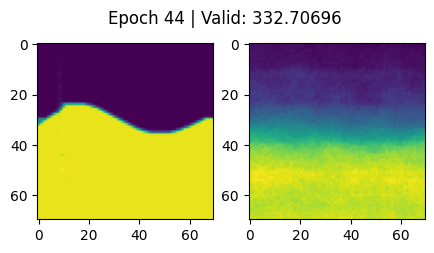

[45] Begin train


train:   0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 245.06941


valid:   0%|          | 0/79 [00:00<?, ?it/s]

Valid loss: 318.56247
[46] Begin train


train:   0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 245.26815


valid:   0%|          | 0/79 [00:00<?, ?it/s]

Valid loss: 337.00813
[47] Begin train


train:   0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 245.64244


valid:   0%|          | 0/79 [00:00<?, ?it/s]

Valid loss: 318.97878
[48] Begin train


train:   0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 245.04360


valid:   0%|          | 0/79 [00:00<?, ?it/s]

Valid loss: 322.37094


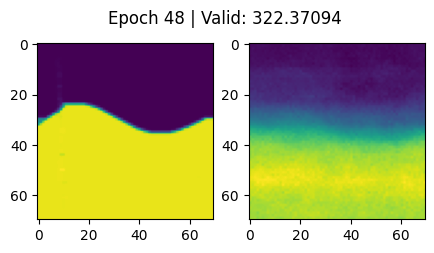

[49] Begin train


train:   0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 245.16624


valid:   0%|          | 0/79 [00:00<?, ?it/s]

Valid loss: 319.56577
[50] Begin train


train:   0%|          | 0/78 [00:00<?, ?it/s]

Train loss: 238.65798


valid:   0%|          | 0/79 [00:00<?, ?it/s]

Valid loss: 320.05285


In [13]:
n_epochs = 50

history = []

for epoch in range(1, n_epochs+1):
    print(f'[{epoch:02d}] Begin train')

    # Train
    model.train()
    train_losses = []
    for inputs, targets in tqdm(dltrain, desc='train', leave=False):
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        optim.zero_grad()
        
        outputs = model(inputs)
        
        loss = criterion(outputs, targets)
        
        loss.backward()
        
        optim.step()

        train_losses.append(loss.item())

    print('Train loss: {:.5f}'.format( np.mean(train_losses) ))

    # Valid
    model.eval()
    valid_losses = []
    for inputs, targets in tqdm(dlvalid, desc='valid', leave=False):
        inputs = inputs.to(device)
        targets = targets.to(device)

        with torch.inference_mode():
            outputs = model(inputs)
        
        loss = criterion(outputs, targets)

        valid_losses.append(loss.item())
    
    print('Valid loss: {:.5f}'.format( np.mean(valid_losses)) )
    history.append({
        'train': np.mean(train_losses),
        'valid': np.mean(valid_losses)
    })

    # Plot last result
    if epoch % 4 == 0:
        y = targets[0, 0].detach().cpu()
        y_pred = outputs[0, 0].detach().cpu()
        
        fig, ax = plt.subplots(1, 2, figsize=(5, 2.5))
        fig.suptitle(f'Epoch {epoch} | Valid: {np.mean(valid_losses):.5f}')
        ax[0].imshow(y)
        ax[1].imshow(y_pred)
        plt.show()


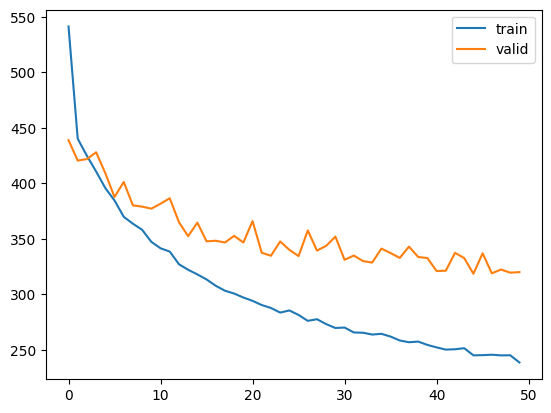

In [14]:
pd.DataFrame(history).plot();

## Predict test

In [15]:
import csv  # Use "low-level" CSV to save memory on predictions

In [16]:
%%time
test_files = list(Path('/kaggle/input/waveform-inversion/test').glob('*.npy'))
len(test_files)

CPU times: user 263 ms, sys: 33.1 ms, total: 296 ms
Wall time: 686 ms


65818

In [17]:
x_cols = [f'x_{i}' for i in range(1, 70, 2)]
fieldnames = ['oid_ypos'] + x_cols

In [18]:
class TestDataset(Dataset):
    def __init__(self, test_files):
        self.test_files = test_files


    def __len__(self):
        return len(self.test_files)


    def __getitem__(self, i):
        test_file = self.test_files[i]

        return np.load(test_file), test_file.stem

In [19]:
ds = TestDataset(test_files)
dl = DataLoader(ds, batch_size=8, num_workers=4, pin_memory=True)

In [20]:
# Train
model.eval()
with open('submission.csv', 'wt', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    
    for inputs, oids_test in tqdm(dl, desc='test'):
        inputs = inputs.to(device)
        with torch.inference_mode():
            outputs = model(inputs)

        y_preds = outputs[:, 0].cpu().numpy()
        
        for y_pred, oid_test in zip(y_preds, oids_test):
            for y_pos in range(70):
                row = dict(
                    zip(
                        x_cols,
                        [y_pred[y_pos, x_pos] for x_pos in range(1, 70, 2)]
                    )
                )
                row['oid_ypos'] = f"{oid_test}_y_{y_pos}"
            
                writer.writerow(row)

test:   0%|          | 0/8228 [00:00<?, ?it/s]